In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import datetime
import gc
from tqdm import tqdm

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')


import scipy
from scipy import hstack


from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.feature_selection import SelectKBest, f_regression
from joblib import dump, load

**Loading data**

In [ ]:
import scipy.sparse
X_train = scipy.sparse.load_npz("/content/train_final.npz")
y_train = np.load('/content/y_train.npy')

X_cv = scipy.sparse.load_npz("/content/cv_final.npz")
y_cv = np.load('/content/y_cv.npy')

# X_test = scipy.sparse.load_npz("test_final.npz")
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((1332967, 48049), (1332967,), (148108, 48049), (148108,))

### 6.3. SVM Regression

#### Hyper parameter tuning using RandomizedSearchCV

RMSLE for C= 0.01 is 1.1998807734781873
RMSLE for C= 0.03 is 1.0364695453634454
RMSLE for C= 0.1 is 0.7024857601791953
RMSLE for C= 0.3 is 0.4582752436724755
RMSLE for C= 1 is 0.953573044738544
RMSLE for C= 3 is 1.030394727065633
RMSLE for C= 10 is 0.6245710889122239


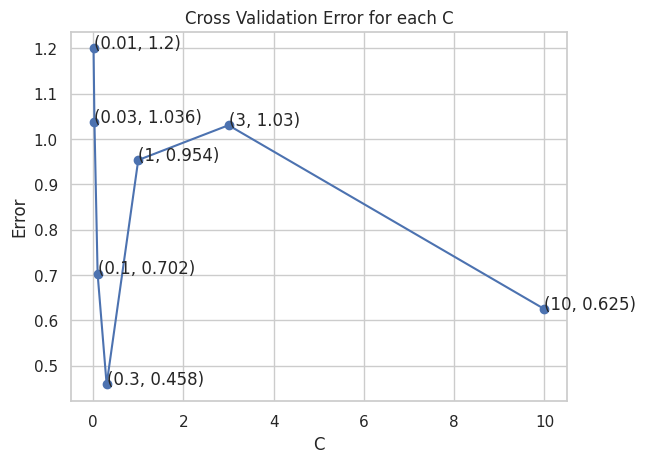

In [ ]:
c_param = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
cv_rmsle_array=[]

for i in c_param:
    model = SVR(C=i, max_iter=200)
    model.fit(X_train, y_train)
    preds_cv = model.predict(X_cv)
    cv_err = sqrt(mse(y_cv, preds_cv))
    cv_rmsle_array.append(cv_err)

    print('RMSLE for C=',i, 'is', cv_err)

best_C = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(c_param, cv_rmsle_array)
ax.scatter(c_param, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((c_param[i],np.round(txt,3)), (c_param[i],cv_rmsle_array[i]))
plt.title("Cross Validation Error for each C")
plt.xlabel("C")
plt.ylabel("Error")
plt.show()

#### Training and testing using best parameters 

In [ ]:
best_C = c_param[best_C]
print('Best C: ', best_C)
model = SVR(C=best_C, max_iter=200)
model.fit(X_train, y_train)
dump(model, 'model_svr.joblib')

Best C:  0.3


['model_svr.joblib']

In [ ]:
svr_preds_tr = model.predict(X_train)
svr_preds_cv = model.predict(X_cv)
print('Train RMSLE:', sqrt(mse(y_train, svr_preds_tr)))

svr_rmsle = sqrt(mse(y_cv, svr_preds_cv))
print("Cross validation RMSLE: ", svr_rmsle)

Train RMSLE: 0.44258492724557275
Cross validation RMSLE:  0.4582752436724755


In [ ]:
X_test = scipy.sparse.load_npz("test_final.npz")
svr_preds_te = model.predict(X_test)

submission_df = pd.read_csv('/content/ridge_submission.csv')

submission_df['price'] = np.exp(svr_preds_te) - 1

submission_df.to_csv('svr_submission.csv', index=False)

### 6.4. RandomForest Regression

#### Hyper parameter tuning using RandomizedSearchCV

RMSLE for N=10 is 0.47726484207331704	 elapsed time:0:50:46.070387
RMSLE for N=20 is 0.4689010895169118	 elapsed time:2:29:37.554237


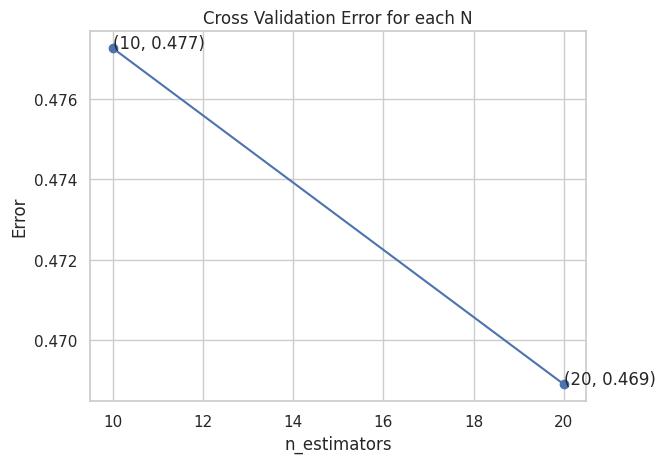

In [ ]:
dt = datetime.datetime #to track time

estimators = [10, 20]
cv_rmsle_array=[]
t0 = dt.now()
for i in estimators:
    model = RandomForestRegressor(n_estimators=i, min_samples_split=10, max_features='sqrt', max_samples=0.9, random_state=42)
    model.fit(X_train, y_train)
    preds_cv = model.predict(X_cv)
    cv_err = sqrt(mse(y_cv, preds_cv))
    cv_rmsle_array.append(cv_err)

    print (f'RMSLE for N={i} is {cv_err}\t elapsed time:{dt.now() - t0}')

best_N = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(estimators, cv_rmsle_array)
ax.scatter(estimators, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((estimators[i],np.round(txt,3)), (estimators[i],cv_rmsle_array[i]))
plt.title("Cross Validation Error for each N")
plt.xlabel("n_estimators")
plt.ylabel("Error")
plt.show()

**Training RandomForest Regressor with higher values of n_estimators was taking tremendous amount of time without giving any results. Due to this reason, we have trained it with less number of estimators. The above code itself took approx. 3 hrs and hence, we did not train further.**

#### Training and testing using best parameters 

In [ ]:
best_N = estimators[best_N]
print('Best n_estimators: ', best_N)
model = RandomForestRegressor(n_estimators=best_N, min_samples_split=10, max_features='sqrt', max_samples=0.9, random_state=42)
model.fit(X_train, y_train)
dump(model, 'model_rf.joblib')


Best n_estimators:  20


['model_rf.joblib']

In [ ]:
# X_test = scipy.sparse.load_npz("test_final.npz")

In [ ]:
rf_preds_tr = model.predict(X_train)
rf_preds_cv = model.predict(X_cv)
# rf_preds_te = model.predict(X_test)

print('Train RMSLE:', sqrt(mse(y_train, rf_preds_tr)))

rf_rmsle = sqrt(mse(y_cv, rf_preds_cv))
print("Cross validation RMSLE: ", rf_rmsle)

Train RMSLE: 0.2763008912850397
Cross validation RMSLE:  0.4689010895169118


In [ ]:
#rf_preds_te = model.predict(X_test)
#submission_df['price'] = np.exp(rf_preds_te) - 1

#submission_df.to_csv('rf_submission.csv', index=False)

### 6.5. LightGBM Regression

#### Hyper parameter tuning using RandomizedSearchCV

In [ ]:
lgb_model = LGBMRegressor(subsample=0.9)

params = {'learning_rate': uniform(0, 1),
          'n_estimators': sp_randint(200, 1500),
          'num_leaves': sp_randint(20, 200),
          'max_depth': sp_randint(2, 15),
          'min_child_weight': uniform(0, 2),
          'colsample_bytree': uniform(0, 1),
         }
lgb_random = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=10, cv=3, random_state=42, 
                                scoring='neg_root_mean_squared_error', verbose=10, return_train_score=True)
lgb_random = lgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122


In [ ]:
df1 = pd.DataFrame(lgb_random.cv_results_)
df1[['param_learning_rate', 'param_n_estimators', 'param_num_leaves', 'param_max_depth', 'param_min_child_weight', 'param_colsample_bytree', 'mean_train_score', 'mean_test_score']]

In [ ]:
best_params = lgb_random.best_params_
print(best_params)

#### Training and testing using best parameters 

In [ ]:
model = LGBMRegressor(**best_params, subsample=0.9, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
dump(model, 'model_lgbm.joblib')

In [ ]:
X_cv = scipy.sparse.load_npz("/content/cv_final.npz")
y_cv = np.load('/content/y_cv.npy')

X_test = scipy.sparse.load_npz("/content/test_final.npz")

In [ ]:
lgb_preds_tr = model.predict(X_train)
lgb_preds_cv = model.predict(X_cv)
lgb_preds_te = model.predict(X_test)

print('Train RMSLE:', sqrt(mse(y_train, lgb_preds_tr)))

lgb_rmsle = sqrt(mse(y_cv, lgb_preds_cv))
print("Cross validation RMSLE: ", lgb_rmsle)

**Creating submission file**

In [ ]:
submission_df = pd.read_csv('/content/ridge_submission.csv')

submission_df['price'] = np.exp(lgb_preds_te) - 1

submission_df.to_csv('lgb_submission.csv', index=False)

## Summary

In [ ]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=["Model", "Feature Space", "Train_RMSLE", "Validation_RMSLE", "Kaggle_RMSLE(Public)"]
x.add_row(["Ridge", "FeatureEngg + cat_OHE + text_TFIDF", "0.3834", "0.4419", "0.45444"])
x.add_row(["SVR", "Kbest text&cat + Ridge Preds + MNB Preds", "0.4426", "0.4583", "-"])
x.add_row(["LightGBM", "Kbest text&cat + Ridge Preds + MNB Preds", "0.35074", "0.48775", "0.45823"])

print(x)

- **We are able to get pretty decent results with ML models with feature engineering and standard text vectorization.**

- **In order to get more accurate predictions, we should try Deep Learning models.**

In [11]:
## Idea for this code is taken from the kernel https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
## Thanks to the authors for their elegant idea of using MLPs for this problem.

import warnings
warnings.filterwarnings('ignore')
import os
import gc
import time
from datetime import datetime

from contextlib import contextmanager

import keras as ks
import pandas as pd
import numpy as np
import scipy
import tensorflow as tf
from keras.models import load_model

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer as Tfidf


from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.model_selection import KFold
from joblib import dump,load

In [12]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [13]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df['name'] = df['name'].fillna('') + ' ' + df['brand_name'].fillna('')
    df['text'] = df['item_description'].fillna('') + ' ' + df['name'] + ' ' + df['category_name'].fillna('')
    return df[['name', 'text', 'shipping', 'item_condition_id']]

### Loading train data and splitting for Cross Validation

In [14]:
def load_train():
    
    train = pd.read_table('train.tsv')
    train = train[train['price'] > 0].reset_index(drop=True)
    cv = KFold(n_splits=20, shuffle=True, random_state=42)
    train_ids, valid_ids = next(cv.split(train))
    train, valid = train.iloc[train_ids], train.iloc[valid_ids]

    global y_scaler
    y_scaler = StandardScaler()

    global train_price, valid_price 
    train_price = train['price'].values.reshape(-1, 1)
    valid_price = valid['price'].values.reshape(-1, 1)

    y_train = y_scaler.fit_transform(np.log1p(train_price))
    
    y_valid = y_scaler.transform(np.log1p(valid_price))

    return train, valid, y_train, y_valid

### Pre-processing and featurization of train data

In [15]:
def process_train(train, valid):
    
    global vectorizer1, vectorizer2, vectorizer3, vectorizer4
    with timer('process train'):
        train = preprocess(train)
        vectorizer1 = Tfidf(max_features=100000, token_pattern='\w+', dtype=np.float32)
        train_namevec  = vectorizer1.fit_transform(train['name'].values)

        vectorizer2 = Tfidf(max_features=100000, token_pattern='\w+', ngram_range=(1, 2), dtype=np.float32)
        train_textvec  = vectorizer2.fit_transform(train['text'].values)

        vectorizer3 = OneHotEncoder(dtype=np.float32)
        train_shipvec = vectorizer3.fit_transform(train['shipping'].values.reshape(-1, 1))

        vectorizer4 = OneHotEncoder(dtype=np.float32)
        train_conditionvec = vectorizer4.fit_transform(train['item_condition_id'].values.reshape(-1, 1))

        X_train = hstack((train_namevec, train_textvec, train_shipvec, train_conditionvec)).tocsr()

    with timer('process valid'):
        valid = preprocess(valid)

        valid_namevec  = vectorizer1.transform(valid['name'].values)

        valid_textvec  = vectorizer2.transform(valid['text'].values)

        valid_shipvec = vectorizer3.transform(valid['shipping'].values.reshape(-1, 1))

        valid_conditionvec = vectorizer4.transform(valid['item_condition_id'].values.reshape(-1, 1))

        X_valid = hstack((valid_namevec, valid_textvec, valid_shipvec, valid_conditionvec)).tocsr()
    
        # Binarizing input
        Xb_train, Xb_valid = [x.astype(np.bool).astype(np.float32) for x in [X_train, X_valid]]
        
    
    return X_train, X_valid, Xb_train, Xb_valid 

### Processing test data

In [16]:
def load_process_test():

    test = pd.read_table('test.tsv')

    global predictions
    predictions = pd.DataFrame(test['test_id'])

    with timer('process test'):
        test = preprocess(test)

        test_namevec  = vectorizer1.transform(test['name'].values)

        test_textvec  = vectorizer2.transform(test['text'].values)

        test_shipvec = vectorizer3.transform(test['shipping'].values.reshape(-1, 1))

        test_conditionvec = vectorizer4.transform(test['item_condition_id'].values.reshape(-1, 1))

        X_test = hstack((test_namevec, test_textvec, test_shipvec, test_conditionvec)).tocsr()
    
        # Binarizing input
        Xb_test = X_test.astype(np.bool).astype(np.float32)
    
    return X_test, Xb_test


### Model 1

In [17]:
def run_model1(X_train, y_train, X_valid, y_valid):
    '''- returns an MLP model trained on tfidf vectorized sparse input.
    - Does not perform best on binarized input.
    - Uses Adam optimizer with constant learning rate. 
    - trains 2 epochs, Batch size is doubled at every epoch to speed up the optimization'''

    model_in = ks.Input(shape=(X_train.shape[1],), dtype='float32', sparse=True)
    out = ks.layers.Dense(256, activation='relu')(model_in)
    # out = ks.layers.Dropout(0.1)(out)     ## performance is better without dropouts
    out = ks.layers.Dense(64, activation='relu')(out)
    # out = ks.layers.Dropout(0.1)(out)
    out = ks.layers.Dense(64, activation='relu')(out)
    # out = ks.layers.Dropout(0.2)(out)
    out = ks.layers.Dense(32, activation='relu')(out)
    out = ks.layers.Dense(1)(out)
    model = ks.Model(model_in, out)
    
    model.compile(loss='mean_squared_error', optimizer=ks.optimizers.Adam(lr=3e-3))
    for i in range(2):
        with timer(f'epoch {i + 1}'):
            model.fit(x=X_train, y=y_train, batch_size=2**(9 + i), epochs=1, verbose=1, validation_data=(X_valid, y_valid))
    
    return model


### Model 2

In [18]:
def run_model2(Xb_train, y_train, Xb_valid, y_valid):
    '''- returns an MLP model trained on binarized sparse input.
    - Does not perform best on non-binarized(regular) input.
    - Uses Adam optimizer with constant learning rate. 
    - trains 3 epochs, Batch size is doubled at every epoch to speed up the optimization'''
    
    model_in = ks.Input(shape=(Xb_train.shape[1],), dtype='float32', sparse=True)
    out = ks.layers.Dense(256, activation='relu')(model_in)
    # out = ks.layers.Dropout(0.1)(out)     ## performance is better without dropouts
    out = ks.layers.Dense(64, activation='relu')(out)
    # out = ks.layers.Dropout(0.1)(out)
    out = ks.layers.Dense(64, activation='relu')(out)
    # out = ks.layers.Dropout(0.2)(out)
    out = ks.layers.Dense(32, activation='relu')(out)
    out = ks.layers.Dense(1)(out)
    model = ks.Model(model_in, out)
    
    model.compile(loss='mean_squared_error', optimizer=ks.optimizers.Adam(lr=3e-3))
    for i in range(3):
        with timer(f'epoch {i + 1}'):
            model.fit(x=Xb_train, y=y_train, batch_size=2**(9 + i), epochs=1, verbose=1, validation_data=(Xb_valid, y_valid))
    
    return model

### Main function

In [20]:
DEVELOP = True # Set to True for only trainng and validation

def main():

    start_time = datetime.now()

    print('\n\nLoading and processing train data.....')
    train, valid, y_train, y_valid = load_train()

    X_train, X_valid, Xb_train, Xb_valid = process_train(train, valid)
    print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

    del train, valid
    gc.collect()

    ## Running model1 on regualr data X_train, X_valid
    print('\n\nRunning model on regular (non-binary) input.....')
    model1 = run_model1(X_train, y_train, X_valid, y_valid)     
    dump(model1, 'model1_NLP.joblib')
    model1.summary()
    pred1 = model1.predict(X_valid)[:, 0]
    y_pred = np.expm1(y_scaler.inverse_transform(pred1.reshape(-1, 1))[:, 0])
    print('1st run val RMSLE: {:.4f}'.format(np.sqrt(msle(valid_price, y_pred))))
    
    ## Running again
    model2 = run_model1(X_train, y_train, X_valid, y_valid)
    dump(model2, 'model2_NLP.joblib')
    model2.summary()
    pred2 = model2.predict(X_valid)[:, 0]
    y_pred = np.expm1(y_scaler.inverse_transform(pred2.reshape(-1, 1))[:, 0])
    print('2nd run val RMSLE: {:.4f}'.format(np.sqrt(msle(valid_price, y_pred))))
    


    ## Running model2 on binarized data Xb_train, Xb_valid
    print('\n\nRunning model on binarized input.....')
    model3 = run_model2(Xb_train, y_train, Xb_valid, y_valid)
    dump(model3, 'model3_NLP.joblib')
    model3.summary()
    pred3 = model3.predict(Xb_valid)[:, 0]
    y_pred = np.expm1(y_scaler.inverse_transform(pred3.reshape(-1, 1))[:, 0])
    print('3rd run val RMSLE: {:.4f}'.format(np.sqrt(msle(valid_price, y_pred))))
    


    ## Running again
    model4 = run_model2(Xb_train, y_train, Xb_valid, y_valid)
    dump(model4, 'model4_NLP.joblib')
    model4.summary()
    pred4 = model4.predict(Xb_valid)[:, 0]
    y_pred = np.expm1(y_scaler.inverse_transform(pred4.reshape(-1, 1))[:, 0])
    print('4th run val RMSLE: {:.4f}'.format(np.sqrt(msle(valid_price, y_pred))))
    


    ## Final Prediction = weighted average of predictions of 4 models/runs
    print('\n\nEnsemble (weighted average of predictions from 4 models/runs).....')
    y_pred = np.average([pred1, pred2, pred3, pred4], weights=[0.33, 0.33, 0.17, 0.17], axis=0)
    y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
    print('Final valid RMSLE: {:.4f}'.format(np.sqrt(msle(valid_price, y_pred))))

    if DEVELOP==False:
        ## This block loads and predicts on test data if DEVELOP is not set

        # print('\n\nLoading and processing test data.....')
        X_test, Xb_test = load_process_test()
        print(X_test.shape, Xb_test.shape)

        with timer('predict test'):
            test_pred1 = model1.predict(X_test)[:, 0]
            test_pred2 = model2.predict(X_test)[:, 0]
            test_pred3 = model3.predict(Xb_test)[:, 0]
            test_pred4 = model4.predict(Xb_test)[:, 0]


        test_pred = np.average([test_pred1, test_pred2, test_pred3, test_pred4], weights=[0.33, 0.33, 0.17, 0.17], axis=0)
        test_pred = np.expm1(y_scaler.inverse_transform(test_pred.reshape(-1, 1))[:, 0])

        print('\n\nCreating submisssion file.....')
        predictions['price'] = test_pred

        predictions.to_csv('predictions.csv', index=False)


    print(f'Code finished execution in {datetime.now() - start_time}')

if __name__ == '__main__':
    main()



Loading and processing train data.....
[process train] done in 123 s
[process valid] done in 9 s
(1407577, 200007) (1407577, 1) (74084, 200007) (74084, 1)


Running model on regular (non-binary) input.....
2750/2750 [==============================] - 26s 8ms/step - loss: 0.3439 - val_loss: 0.2999
[epoch 1] done in 31 s
1375/1375 [==============================] - 15s 9ms/step - loss: 0.2027 - val_loss: 0.2902
[epoch 2] done in 20 s
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200007)]          0         
                                                                 
 dense_10 (Dense)            (None, 256)               51202048  
                                                                 
 dense_11 (Dense)            (None, 64)                16448     
                                                                 
 dense_12 (Dense)

- **I also experimented with diffrent activation units ('tanh', 'sigmoid', 'linear', 'relu'). 'relu' performs significantly better that rest all.**
- **The validation RMSLE I got was 0.3846.**